# Aim of this notebook

* To construct the singular curve of universal type to finalize the solution of the optimal control problem

# Preamble

In [1]:
from sympy import *
init_printing(use_latex='mathjax')

# Plotting
%matplotlib inline
## Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
## Import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker
## Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.25,
        rc={"xtick.major.size": 6, "ytick.major.size": 6,
            'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Times']})

import pandas as pd
pd.set_option('mode.chained_assignment',None)

import numpy as np
from scipy.optimize import fsolve, root
from scipy.integrate import ode
backend = 'dopri5'
import warnings

# Timer
import time

from copy import deepcopy

from itertools import cycle
palette_size = 10;
clrs = sns.color_palette("Reds",palette_size)
iclrs = cycle(clrs) # iterated colors

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Parameter values

* Birth rate and const of downregulation are defined below in order to fit some experim. data

In [2]:
d = .13 # death rate
α = .3 # low equilibrium point at expression of the main pathway (high equilibrium is at one)
θ = .45 # threshold value for the expression of the main pathway
κ = 40 # robustness parameter

* Symbolic variables - the list insludes μ & μbar, because they will be varied later

In [3]:
σ, φ0, φ, x, μ, μbar = symbols('sigma, phi0, phi, x, mu, mubar')

* Main functions

In [4]:
A = 1-σ*(1-θ)
Eminus = (α*A-θ)**2/2
ΔE = A*(1-α)*((1+α)*A/2-θ)
ΔEf = lambdify(σ,ΔE)

* Birth rate and cost of downregulation

In [5]:
b = (0.1*(exp(κ*(ΔEf(1)))+1)-0.14*(exp(κ*ΔEf(0))+1))/(exp(κ*ΔEf(1))-exp(κ*ΔEf(0))) # birth rate
χ = 1-(0.14*(exp(κ*ΔEf(0))+1)-b*exp(κ*ΔEf(0)))/b
b, χ

(0.140168330860362, 0.325961223954473)

In [6]:
c_relative = 0.05
c = c_relative*(b-d)/b+(1-c_relative)*χ/(exp(κ*ΔEf(0))+1) # cost of resistance
c

0.00476805892072291

* Hamiltonian *H* and a part of it ρ that includes the control variable σ

In [7]:
h = b*(χ/(exp(κ*ΔE)+1)*(1-x)+c*x)
H = -φ0 + φ*(b*(χ/(exp(κ*ΔE)+1)-c)*x*(1-x)+μ*(1-x)/(exp(κ*ΔE)+1)-μbar*exp(-κ*Eminus)*x) + h
ρ = (φ*(b*χ*x+μ)+b*χ)/(exp(κ*ΔE)+1)*(1-x)-φ*μbar*exp(-κ*Eminus)*x
H, ρ

⎛  ⎛                                                                        2 
⎜  ⎜                μ⋅(-x + 1)                         -20⋅(-0.165⋅σ - 0.15)  
⎜φ⋅⎜────────────────────────────────────────── - μ̅⋅x⋅ℯ                       
⎜  ⎜ 40⋅(-0.385⋅σ + 0.7)⋅(-0.3575⋅σ + 0.2)                                    
⎝  ⎝ℯ                                      + 1                                

                                                                              
    ⎛                                    0.045689440686899             ⎞      
+ x⋅⎜-0.000668330860361588 + ──────────────────────────────────────────⎟⋅(-x +
    ⎜                         40⋅(-0.385⋅σ + 0.7)⋅(-0.3575⋅σ + 0.2)    ⎟      
    ⎝                        ℯ                                      + 1⎠      

   ⎞                                                                          
   ⎟                                         0.045689440686899⋅(-x + 1)       
 1)⎟ - φ₀ + 0.000668330860361588⋅x + ─────────────

* Same but for no treatment (σ = 0)

In [8]:
h0 = h.subs(σ,0)
H0 = H.subs(σ,0)
ρ0 = ρ.subs(σ,0)
H0, ρ0

(φ⋅(0.00368423989943599⋅μ⋅(-x + 1) - 0.637628151621773⋅μ̅⋅x - 0.0005⋅x⋅(-x + 1
)) - φ₀ + 0.0005⋅x + 0.000168330860361587, -0.637628151621773⋅μ̅⋅φ⋅x + 0.00368
423989943599⋅(-x + 1)⋅(φ⋅(μ + 0.045689440686899⋅x) + 0.045689440686899))

* Machinery: definition of the Poisson brackets

In [9]:
PoissonBrackets = lambda H1, H2: diff(H1,x)*diff(H2,φ)-diff(H1,φ)*diff(H2,x)

* Necessary functions and defining the right hand side of dynamical equations

In [10]:
ρf = lambdify((x,φ,σ,μ,μbar),ρ)
ρ0f = lambdify((x,φ,μ,μbar),ρ0)
dxdτ = lambdify((x,φ,σ,μ,μbar),-diff(H,φ))
dφdτ = lambdify((x,φ,σ,μ,μbar),diff(H,x))
dVdτ = lambdify((x,σ),h)
dρdσ = lambdify((σ,x,φ,μ,μbar),diff(ρ,σ))
dδρdτ = lambdify((x,φ,σ,μ,μbar),-PoissonBrackets(ρ0-ρ,H))
def ode_rhs(t,state,μ,μbar):
    x, φ, V, δρ = state
    σs = [0,1]
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    if ρf(x,φ,σstar,μ,μbar) < ρ0f(x,φ,μ,μbar):
        sgm = 0
    else:
        sgm = σstar
    return [dxdτ(x,φ,sgm,μ,μbar),dφdτ(x,φ,sgm,μ,μbar),dVdτ(x,sgm),dδρdτ(x,φ,σstar,μ,μbar)]

In [11]:
def get_primary_field(name, experiment,μ,μbar):
    solutions = {}
    solver = ode(ode_rhs).set_integrator(backend)
    τ0 = experiment['τ0']
    tms = np.linspace(τ0,experiment['T_end'],1e3+1)
    for x0 in experiment['x0']:
        δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
        solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
        sol = []; k = 0;
        while (solver.t < experiment['T_end']) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
            solver.integrate(tms[k])
            sol.append([solver.t]+list(solver.y))
            k += 1
        solutions[x0] = {'solution': sol}
    for x0, entry in solutions.items():
        entry['τ'] = [entry['solution'][j][0] for j in range(len(entry['solution']))]
        entry['x'] = [entry['solution'][j][1] for j in range(len(entry['solution']))]
        entry['φ'] = [entry['solution'][j][2] for j in range(len(entry['solution']))]
        entry['V'] = [entry['solution'][j][3] for j in range(len(entry['solution']))]
        entry['δρ'] = [entry['solution'][j][4] for j in range(len(entry['solution']))]
    return solutions
def get_δρ_value(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    while (solver.t < tme) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tme)
        sol = [solver.t]+list(solver.y)
    return solver.y[3]
def get_δρ_ending(params,μ,μbar):
    tme, x0 = params
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (_k<len(tms)):# and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    #print(sol)
    return(sol[0][3],(sol[1][3]-sol[0][3])/δτ)
def get_state(tme,x0,μ,μbar):
    solver = ode(ode_rhs).set_integrator(backend)
    δρ0 = ρ0.subs(x,x0).subs(φ,0)-ρ.subs(x,x0).subs(φ,0).subs(σ,1.)
    solver.set_initial_value([x0,0,0,δρ0],0.).set_f_params(μ,μbar)
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    _k = 0; sol = []
    while (solver.t < tms[-1]) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append(solver.y)
        _k += 1
    return(list(sol[0])+[(sol[1][3]-sol[0][3])/δτ])

# Machinery for the universal line

* To find the universal singular curve we need to define two parameters

In [12]:
γ0 = PoissonBrackets(PoissonBrackets(H,H0),H)
γ1 = PoissonBrackets(PoissonBrackets(H0,H),H0)

* The dynamics

In [13]:
dxdτSingExpr = -(γ0*diff(H0,φ)+γ1*diff(H,φ))/(γ0+γ1)
dφdτSingExpr = (γ0*diff(H0,x)+γ1*diff(H,x))/(γ0+γ1)
dVdτSingExpr = (γ0*h0+γ1*h)/(γ0+γ1)
σSingExpr = γ1*σ/(γ0+γ1)

* Machinery for Python: lambdify the functions above

In [14]:
dxdτSing = lambdify((x,φ,σ,μ,μbar),dxdτSingExpr)
dφdτSing = lambdify((x,φ,σ,μ,μbar),dφdτSingExpr)
dVdτSing = lambdify((x,φ,σ,μ,μbar),dVdτSingExpr)
σSing = lambdify((x,φ,σ,μ,μbar),σSingExpr)

In [15]:
def ode_rhs_Sing(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σstar = 1.;
    #print([σstar,σSing(x,φ,σstar,μ,μbar)])
    return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτSing(x,φ,σstar,μ,μbar)]
# def ode_rhs_Sing(t,state,μ,μbar):
#     x, φ, V = state
#     if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
#         σstar = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
#     else:
#         σstar = 1.;
#     σTrav = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-dxdτSing(x,φ,σstar,μ,μbar),.6)[0]
#     print([σstar,σTrav])
#     return [dxdτSing(x,φ,σstar,μ,μbar),dφdτSing(x,φ,σstar,μ,μbar),dVdτ(x,σTrav)]
def get_universal_curve(end_point,tmax,Nsteps,μ,μbar):
    tms =  np.linspace(end_point[0],tmax,Nsteps);
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tms[-1]):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_σ_universal(tme,end_point,μ,μbar):
    δτ = 1.0e-8; tms = [tme,tme+δτ]
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    _k = 0; sol = []
    while (solver.t < tme+δτ):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    x, φ = sol[0][:2]
    sgm = fsolve(lambda σ: dxdτ(x,φ,σ,μ,μbar)-(sol[1][0]-sol[0][0])/δτ,θ/2)[0]
    return sgm
def get_state_universal(tme,end_point,μ,μbar):
    solver = ode(ode_rhs_Sing).set_integrator(backend)
    solver.set_initial_value(end_point[1:4],end_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)

In [16]:
def ode_rhs_with_σstar(t,state,μ,μbar):
    x, φ, V = state
    if (dρdσ(1.,x,φ,μ,μbar)<0) and (dρdσ(θ,x,φ,μ,μbar)>0):
        σ = fsolve(dρdσ,.8,args=(x,φ,μ,μbar,))[0]
    else:
        σ = 1.;
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def ode_rhs_with_given_σ(t,state,σ,μ,μbar):
    x, φ, V = state
    return [dxdτ(x,φ,σ,μ,μbar),dφdτ(x,φ,σ,μ,μbar),dVdτ(x,σ)]
def get_trajectory_with_σstar(starting_point,tmax,Nsteps,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,Nsteps)
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_trajectory_with_given_σ(starting_point,tmax,Nsteps,σ,μ,μbar):
    tms = np.linspace(starting_point[0],tmax,100)
    solver = ode(ode_rhs_with_given_σ).set_integrator(backend)
    solver.set_initial_value(starting_point[1:],starting_point[0]).set_f_params(σ,μ,μbar)
    sol = []; _k = 0;
    while solver.t < max(tms) and (solver.y[0]<=1.) and (solver.y[0]>=0.):
        solver.integrate(tms[_k])
        sol.append([solver.t]+list(solver.y))
        _k += 1
    return sol
def get_state_with_σstar(tme,starting_point,μ,μbar):
    solver = ode(ode_rhs_with_σstar).set_integrator(backend)
    solver.set_initial_value(starting_point[1:4],starting_point[0]).set_f_params(μ,μbar)
    solver.integrate(tme)
    return [solver.t]+list(solver.y)
def get_finalizing_point_from_universal_curve(tme,tmx,end_point,μ,μbar):
    unv_point = get_state_universal(tme,end_point,μ,μbar)
    return get_state_with_σstar(tmx,unv_point,μ,μbar)[1]

# Field of optimal trajectories as the solution of the Bellman equation

* μ & μbar are varied by *T* and *T*bar ($\mu=1/T$ and $\bar\mu=1/\bar{T}$)

Parameters: μ = 0.03571, μbar = 0.01667
Ending point for the switching line: τ = 26.0 days, x = 68.2%
Checking the solution - should give zero values: 
(-1.1786431431622271e-07, -2.0028947820568984e-07)
* Constructing the primary field
* Constructing the switching curve
* Constructing the universal curve
* Finding the last characteristic
The last point on the universal line:
[152.66150901362457, 0.6807639270038652, -0.5280863629458904, 0.7505674331551329]
Final state:
[180.0, -7.969791493422917e-12, -1.1394982786543384, 1.4121873321573895]
Fold-change in tumor size: 1.52


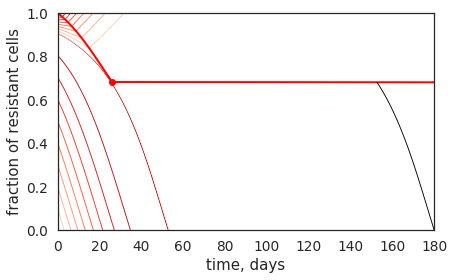

In [17]:
tmx = 180.
end_switching_curve = {'t': 24., 'x': .9/.8} 
# for Τ, Τbar in zip([28]*5,[14,21,28,35,60]):
for Τ, Τbar in zip([28],[60]):
    μ = 1./Τ; μbar = 1./Τbar
    print("Parameters: μ = %.5f, μbar = %.5f"%(μ,μbar))
    end_switching_curve['t'], end_switching_curve['x'] = fsolve(get_δρ_ending,(end_switching_curve['t'],.8*end_switching_curve['x']),args=(μ,μbar),xtol=1.0e-12)
    end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
    print("Ending point for the switching line: τ = %.1f days, x = %.1f%%" % (end_point[0], end_point[1]*100))
    print("Checking the solution - should give zero values: ")
    print(get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar))
    print("* Constructing the primary field")
    experiments = {
        'sol1': { 'T_end': tmx, 'τ0': 0., 'x0': list(np.linspace(0,end_switching_curve['x']-(1e-3),10))+list(np.linspace(end_switching_curve['x']+(1e-6),1.,10)) } }
    primary_field = []
    for name, values in experiments.items():
        primary_field.append(get_primary_field(name,values,μ,μbar))
    print("* Constructing the switching curve")
    switching_curve = []
    x0s = np.linspace(end_switching_curve['x'],1,21); _y = end_switching_curve['t']
    
    for x0 in x0s:
        tme = fsolve(get_δρ_value,_y,args=(x0,μ,μbar))[0]
        if (tme>0):
            switching_curve = switching_curve+[[tme,get_state(tme,x0,μ,μbar)[0]]]
            _y = tme
    print("* Constructing the universal curve")
    universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
    print("* Finding the last characteristic")
    #time0 = time.time()
    tuniv = fsolve(get_finalizing_point_from_universal_curve,tmx-40.,args=(tmx,end_point,μ,μbar,))[0]
    #print("The proccess to find the last characteristic took %0.1f minutes" % ((time.time()-time0)/60.))
    univ_point = get_state_universal(tuniv,end_point,μ,μbar)
    print("The last point on the universal line:")
    print(univ_point)
    last_trajectory = get_trajectory_with_σstar(univ_point,tmx,50,μ,μbar)
    print("Final state:")
    final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
    print(final_state)
    print("Fold-change in tumor size: %.2f"%(exp((b-d)*tmx-final_state[-1])))
    # Plotting
    plt.rcParams['figure.figsize'] = (6.75, 4)
    _k = 0
    for solutions in primary_field:
        for x0, entry in solutions.items():
            plt.plot(entry['τ'], entry['x'], 'k-', linewidth=.9, color=clrs[_k%palette_size])
            _k += 1
    plt.plot([x[0] for x in switching_curve],[x[1] for x in switching_curve],linewidth=2,color="red")
    plt.plot([end_point[0]],[end_point[1]],marker='o',color="red")
    plt.plot([x[0] for x in universal_curve],[x[1] for x in universal_curve],linewidth=2,color="red")
    plt.plot([x[0] for x in last_trajectory],[x[1] for x in last_trajectory],linewidth=.9,color="black")
    plt.xlim([0,tmx]); plt.ylim([0,1]);
    plt.xlabel("time, days"); plt.ylabel("fraction of resistant cells")
    plt.show()
    print()

In [19]:
import csv
from numpy.linalg import norm
File = open("../figures/draft/sensitivity_mu-low_cost.csv", 'w')
File.write("T,Tbar,mu,mubar,sw_start_x,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
writer = csv.writer(File,lineterminator='\n')

end_switching_curve0 = {'t': 40.36, 'x': .92}
end_switching_curve_prev_t = end_switching_curve0['t']
tuniv = tmx-30.
Ts = np.arange(40,3,-1) #Τbars; 
Τbars = np.arange(40,3,-1) #np.arange(120,1,-1) #need to change here if more
for Τ in Ts:
    μ = 1./Τ
    end_switching_curve = deepcopy(end_switching_curve0)
    for Τbar in Τbars:
        μbar = 1./Τbar
        print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
        success = False; err = 1.
        while (not success)|(norm(err)>1e-6):
            end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                                   'x': end_switching_curve['x']-0.002} 
            sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
            end_switching_curve_prev_t = end_switching_curve['t']
            end_switching_curve_prev_x = end_switching_curve['x']
            end_switching_curve['t'], end_switching_curve['x'] = sol.x 
            success = sol.success
            err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
            if (not success): 
                print("! Trying again...", sol.message)
            elif (norm(err)>1e-6):
                print("! Trying again... Convergence is not sufficient")       
        else:
            end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
            print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
            universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
            tuniv = root(get_finalizing_point_from_universal_curve,tuniv,args=(tmx,end_point,μ,μbar)).x
            err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
            univ_point = get_state_universal(tuniv,end_point,μ,μbar)
            print("tuniv = %.2f"%tuniv,"xuniv = %.2f%%"%(100*univ_point[1])," Checking the solution: ",err_tuniv)
            final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
            outcome = exp((b-d)*tmx-final_state[-1])
            print("Fold-change in tumor size: %.2f"%(outcome))
            output = [Τ,Τbar,μ,μbar,end_switching_curve['x'],end_point[0],end_point[1]]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
            writer.writerow(output)
        if (Τbar==Τ):
            end_switching_curve0 = deepcopy(end_switching_curve) 

File.close()

* Parameters: T = 40.0, Tbar = 40.0 (μ = 0.02500, μbar = 0.02500)
Ending point: t = 28.39, x = 85.21%  Checking the solution: (-4.5539529763331224e-14, -5.325837891596065e-15)
tuniv = 150.57 xuniv = 58.76%  Checking the solution:  -9.34266553009877e-13
Fold-change in tumor size: 0.96
* Parameters: T = 40.0, Tbar = 39.0 (μ = 0.02500, μbar = 0.02564)
Ending point: t = 28.25, x = 84.93%  Checking the solution: (-4.28210658223033e-14, -6.917362874613284e-15)
tuniv = 150.73 xuniv = 58.43%  Checking the solution:  -2.6845314859968994e-10
Fold-change in tumor size: 0.94
* Parameters: T = 40.0, Tbar = 38.0 (μ = 0.02500, μbar = 0.02632)
Ending point: t = 28.11, x = 84.64%  Checking the solution: (4.3056312282744235e-14, -3.737931571323276e-15)
tuniv = 150.89 xuniv = 58.09%  Checking the solution:  -3.862080794059253e-11
Fold-change in tumor size: 0.93
* Parameters: T = 40.0, Tbar = 37.0 (μ = 0.02500, μbar = 0.02703)
Ending point: t = 27.97, x = 84.34%  Checking the solution: (-4.019784345171077

Ending point: t = 23.95, x = 72.38%  Checking the solution: (-1.6599387988876553e-07, -5.732707790300333e-07)
tuniv = 155.79 xuniv = 46.64%  Checking the solution:  -3.0531133177191805e-16
Fold-change in tumor size: 0.46
* Parameters: T = 40.0, Tbar = 15.0 (μ = 0.02500, μbar = 0.06667)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 23.69, x = 71.27%  Checking the solution: (-2.5845784911041416e-08, -6.40998185518961e-07)
tuniv = 156.10 xuniv = 45.80%  Checking the solution:  -2.0349924523266338e-10
Fold-change in tumor size: 0.43
* Parameters: T = 40.0, Tbar = 14.0 (μ = 0.02500, μbar = 0.07143)
Ending point: t = 23.40, x = 70.05%  Checking the solution: (-1.172844529440528e-07, -3.761231154322991e-07)
tuniv = 156.33 xuniv = 44.99%  Checking the solution:  7.

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 26.58, x = 81.95%  Checking the solution: (-2.673628462309932e-07, -6.619102967418472e-08)
tuniv = 152.66 xuniv = 55.29%  Checking the solution:  5.102418487723526e-12
Fold-change in tumor size: 0.81
* Parameters: T = 39.0, Tbar = 29.0 (μ = 0.02564, μbar = 0.03448)
Ending point: t = 26.40, x = 81.52%  Checking the solution: (-2.5541493043692233e-07, -2.4656117948991898e-08)
tuniv = 152.85 xuniv = 54.86%  Checking the solution:  2.030181578405177e-12
Fold-change in tumor size: 0.79
* Parameters: T = 39.0, Tbar = 28.0 (μ = 0.02564, μbar = 0.03571)
Ending point: t = 26.23, x = 81.06%  Checking the solution: (-2.1205358929974145e-07, -1.7934334471333708e-09)
tuniv = 153.04 xuniv = 54.41%  Checking the solution:  -5.766068178481021e-12
Fold-change in tumor size: 0.77
* Parameters: T = 39.0, Tbar = 27.0 (μ = 0.02564, μbar = 0.03704)
Ending 

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 21.09, x = 44.48%  Checking the solution: (-2.0179901582493295e-07, -2.8485906480992884e-07)
tuniv = 158.88 xuniv = 30.47%  Checking the solution:  -1.9845236565174673e-15
Fold-change in tumor size: 0.09
* Parameters: T = 38.0, Tbar = 40.0 (μ = 0.02632, μbar = 0.02500)
Ending point: t = 27.74, x = 85.49%  Checking the solution: (-2.7577031658259548e-14, -3.2058139674042193e-15)
tuniv = 151.22 xuniv = 59.40%  Checking the solution:  -1.1741996264191812e-13
Fold-change in tumor size: 0.99
* Parameters: T = 38.0, Tbar = 39.0 (μ = 0.02632, μbar =

Ending point: t = 23.36, x = 72.86%  Checking the solution: (-1.5562804369756172e-07, -4.167872971400492e-07)
tuniv = 156.34 xuniv = 47.33%  Checking the solution:  3.8573616523152054e-11
Fold-change in tumor size: 0.48
* Parameters: T = 38.0, Tbar = 15.0 (μ = 0.02632, μbar = 0.06667)
Ending point: t = 23.09, x = 71.76%  Checking the solution: (-9.817136958655801e-08, -1.7422601236785696e-07)
tuniv = 156.56 xuniv = 46.57%  Checking the solution:  -3.803575510108459e-11
Fold-change in tumor size: 0.45
* Parameters: T = 38.0, Tbar = 14.0 (μ = 0.02632, μbar = 0.07143)
Ending point: t = 22.81, x = 70.56%  Checking the solution: (-1.9856820587761323e-14, -1.045841495883257e-15)
tuniv = 156.82 xuniv = 45.72%  Checking the solution:  1.1414592882008634e-10
Fold-change in tumor size: 0.42
* Parameters: T = 38.0, Tbar = 13.0 (μ = 0.02632, μbar = 0.07692)
Ending point: t = 22.53, x = 69.24%  Checking the solution: (-3.4048283669482066e-13, -2.3733606085606943e-14)
tuniv = 157.13 xuniv = 44.78%  

Ending point: t = 25.47, x = 80.94%  Checking the solution: (-1.709792518202727e-07, -9.265045800387056e-07)
tuniv = 154.20 xuniv = 54.25%  Checking the solution:  4.440892098500626e-16
Fold-change in tumor size: 0.78
* Parameters: T = 37.0, Tbar = 26.0 (μ = 0.02703, μbar = 0.03846)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 25.26, x = 80.44%  Checking the solution: (-4.8523647306420477e-08, -5.086805939805559e-07)
tuniv = 154.26 xuniv = 53.92%  Checking the solution:  4.919092910782297e-12
Fold-change in tumor size: 0.76
* Parameters: T = 37.0, Tbar = 25.0 (μ = 0.02703, μbar = 0.04000)
Ending point: t = 25.04, x = 79.90%  Checking the solution: (1.8080189309686162e-13, 2.0380301003564086e-14)
tuniv = 154.30 xuniv = 53.60%  Checking the solution:  6.877529795668025e-12
Fold-change in tumor size: 0.74
* Parameters: T = 37.0, Tbar = 24.0 (μ = 0.02703, μbar = 0.04167)
Ending poin

Ending point: t = 26.66, x = 84.94%  Checking the solution: (8.637781067599953e-14, 1.0906465233804034e-14)
tuniv = 152.37 xuniv = 59.07%  Checking the solution:  7.163952764344117e-11
Fold-change in tumor size: 0.99
* Parameters: T = 36.0, Tbar = 36.0 (μ = 0.02778, μbar = 0.02778)
Ending point: t = 26.52, x = 84.64%  Checking the solution: (-3.5560113474707514e-14, 3.9418041525798705e-15)
tuniv = 152.54 xuniv = 58.71%  Checking the solution:  1.3586909375362666e-12
Fold-change in tumor size: 0.97
* Parameters: T = 36.0, Tbar = 35.0 (μ = 0.02778, μbar = 0.02857)
Ending point: t = 26.38, x = 84.32%  Checking the solution: (1.263389900305772e-13, -3.8134023358878775e-14)
tuniv = 152.71 xuniv = 58.35%  Checking the solution:  1.6165402350054592e-12
Fold-change in tumor size: 0.95
* Parameters: T = 36.0, Tbar = 34.0 (μ = 0.02778, μbar = 0.02941)
! Trying again... Convergence is not sufficient
Ending point: t = 26.23, x = 83.98%  Checking the solution: (1.9584261478960887e-14, -1.8112742735

Ending point: t = 21.33, x = 66.74%  Checking the solution: (-1.4599839161877085e-07, -4.724135680897728e-08)
tuniv = 158.38 xuniv = 43.33%  Checking the solution:  2.381135566498216e-11
Fold-change in tumor size: 0.34
* Parameters: T = 36.0, Tbar = 10.0 (μ = 0.02778, μbar = 0.10000)
Ending point: t = 21.02, x = 64.93%  Checking the solution: (7.801723125449133e-13, 8.76860724713793e-14)
tuniv = 158.71 xuniv = 42.14%  Checking the solution:  -1.426719853370173e-12
Fold-change in tumor size: 0.31
* Parameters: T = 36.0, Tbar = 9.0 (μ = 0.02778, μbar = 0.11111)
Ending point: t = 20.71, x = 62.87%  Checking the solution: (2.2803538046153914e-12, 1.9712606609030125e-13)
tuniv = 159.05 xuniv = 40.83%  Checking the solution:  -5.3618220974271935e-12
Fold-change in tumor size: 0.27
* Parameters: T = 36.0, Tbar = 8.0 (μ = 0.02778, μbar = 0.12500)
Ending point: t = 20.40, x = 60.51%  Checking the solution: (-9.432141383013226e-08, -1.7177698468397163e-08)
tuniv = 159.39 xuniv = 39.38%  Checking

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 24.03, x = 79.16%  Checking the solution: (-2.340122584961809e-07, -5.426818755588608e-07)
tuniv = 155.56 xuniv = 53.03%  Checking the solution:  -2.317396274875705e-11
Fold-change in tumor size: 0.72
* Parameters: T = 35.0, Tbar = 22.0 (μ = 0.02857, μbar = 0.04545)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 23.81, x = 78.53%  Checking the solution: (-2.8951292994782154e-08, -4.0936322144046575e-08)
tuniv = 155.63 xuniv = 52.62%  Checking the solution:  -4.046346591124461e-13
Fold-change in tumor size: 0.70
* Parameters: T = 35.0, Tbar = 21.0 (μ = 0.02857, μbar = 0.04762)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Endin

Ending point: t = 26.35, x = 86.10%  Checking the solution: (2.1371029623832314e-14, 2.549026363745844e-15)
tuniv = 152.61 xuniv = 60.79%  Checking the solution:  -2.4417162736156683e-11
Fold-change in tumor size: 1.08
* Parameters: T = 34.0, Tbar = 39.0 (μ = 0.02941, μbar = 0.02564)
Ending point: t = 26.22, x = 85.83%  Checking the solution: (-1.4217246044657158e-13, -1.3718015987109654e-14)
tuniv = 152.76 xuniv = 60.46%  Checking the solution:  4.4019787814875144e-12
Fold-change in tumor size: 1.07
* Parameters: T = 34.0, Tbar = 38.0 (μ = 0.02941, μbar = 0.02632)
Ending point: t = 26.09, x = 85.56%  Checking the solution: (5.832294359175484e-14, -2.9362304087024184e-14)
tuniv = 152.92 xuniv = 60.13%  Checking the solution:  1.6569433325397398e-11
Fold-change in tumor size: 1.05
* Parameters: T = 34.0, Tbar = 37.0 (μ = 0.02941, μbar = 0.02703)
Ending point: t = 25.96, x = 85.27%  Checking the solution: (1.4982381027955688e-14, 1.2033612414377886e-15)
tuniv = 153.08 xuniv = 59.78%  Che

Ending point: t = 21.32, x = 70.39%  Checking the solution: (-1.1757745686897947e-07, -7.934215426929681e-07)
tuniv = 158.54 xuniv = 45.99%  Checking the solution:  1.3609946503123638e-12
Fold-change in tumor size: 0.43
* Parameters: T = 34.0, Tbar = 12.0 (μ = 0.02941, μbar = 0.08333)
Ending point: t = 21.01, x = 68.97%  Checking the solution: (-1.3833754036067428e-13, -1.6983216034547635e-14)
tuniv = 158.67 xuniv = 45.16%  Checking the solution:  -5.090830534904001e-12
Fold-change in tumor size: 0.40
* Parameters: T = 34.0, Tbar = 11.0 (μ = 0.02941, μbar = 0.09091)
Ending point: t = 20.72, x = 67.38%  Checking the solution: (-1.230571298476398e-07, -6.984380631965968e-08)
tuniv = 159.01 xuniv = 44.04%  Checking the solution:  7.037426197342711e-14
Fold-change in tumor size: 0.36
* Parameters: T = 34.0, Tbar = 10.0 (μ = 0.02941, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending 

! Trying again... Convergence is not sufficient
Ending point: t = 23.90, x = 81.26%  Checking the solution: (-1.1037844824243226e-07, 1.5341859110852893e-08)
tuniv = 155.41 xuniv = 55.58%  Checking the solution:  1.6725509865977983e-12
Fold-change in tumor size: 0.83
* Parameters: T = 33.0, Tbar = 25.0 (μ = 0.03030, μbar = 0.04000)
Ending point: t = 23.72, x = 80.74%  Checking the solution: (2.9055000220275674e-13, 3.550404692893841e-14)
tuniv = 155.62 xuniv = 55.06%  Checking the solution:  -1.9018814301219322e-12
Fold-change in tumor size: 0.81
* Parameters: T = 33.0, Tbar = 24.0 (μ = 0.03030, μbar = 0.04167)
Ending point: t = 23.54, x = 80.20%  Checking the solution: (-1.0331359039375474e-07, -1.970533014804321e-07)
tuniv = 155.90 xuniv = 54.45%  Checking the solution:  -1.32474170522201e-11
Fold-change in tumor size: 0.78
* Parameters: T = 33.0, Tbar = 23.0 (μ = 0.03030, μbar = 0.04348)
Ending point: t = 23.37, x = 79.62%  Checking the solution: (-2.2598609273448745e-07, -6.3367767

Ending point: t = 25.35, x = 85.90%  Checking the solution: (-2.2562038839318323e-14, -6.127043838895062e-15)
tuniv = 153.66 xuniv = 60.88%  Checking the solution:  -7.74375702450314e-12
Fold-change in tumor size: 1.10
* Parameters: T = 32.0, Tbar = 37.0 (μ = 0.03125, μbar = 0.02703)
! Trying again... Convergence is not sufficient
Ending point: t = 25.22, x = 85.62%  Checking the solution: (-2.716494885887091e-14, 3.2590670325531224e-14)
tuniv = 153.81 xuniv = 60.54%  Checking the solution:  -2.6317836798739336e-13
Fold-change in tumor size: 1.08
* Parameters: T = 32.0, Tbar = 36.0 (μ = 0.03125, μbar = 0.02778)
Ending point: t = 25.09, x = 85.33%  Checking the solution: (1.087306971753665e-14, 6.120770091224712e-14)
tuniv = 153.97 xuniv = 60.19%  Checking the solution:  -4.196074043782971e-12
Fold-change in tumor size: 1.06
* Parameters: T = 32.0, Tbar = 35.0 (μ = 0.03125, μbar = 0.02857)
! Trying again... Convergence is not sufficient
Ending point: t = 24.95, x = 85.02%  Checking the 

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 19.77, x = 66.29%  Checking the solution: (-6.514305432975133e-08, -5.466085270729407e-07)
tuniv = 160.09 xuniv = 43.49%  Checking the solution:  3.0044022825137517e-13
Fold-change in tumor size: 0.35
* Parameters: T = 32.0, Tbar = 9.0 (μ = 0.03125, μbar = 0.11111)
Ending point: t = 19.44, x = 64.29%  Checking the solution: (-9.841398071620794e-12, -1.2580832274389082e-12)
tuniv = 160.31 xuniv = 42.28%  Checking the solution:  2.5185409313621676e-12
Fold-change in tumor size: 0.31
* Parameters: T = 32.0, Tbar = 8.0 (μ = 0.03125, μbar = 0.12500)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 19.13, x = 61.98%  Checking the solution: (-7.194069184885366e-08, -2.1190002615847851e-07)
tuniv = 160.70 xuniv = 40.78%  Checking the solution:  5.34019217734993

Ending point: t = 22.03, x = 78.15%  Checking the solution: (6.468707940618599e-13, 8.921038902962659e-14)
tuniv = 157.44 xuniv = 52.95%  Checking the solution:  -9.160588954060245e-13
Fold-change in tumor size: 0.71
* Parameters: T = 31.0, Tbar = 19.0 (μ = 0.03226, μbar = 0.05263)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 21.84, x = 77.40%  Checking the solution: (-1.3408771977341746e-07, -8.007456512994189e-07)
tuniv = 157.92 xuniv = 52.02%  Checking the solution:  1.4615600396616912e-11
Fold-change in tumor size: 0.68
* Parameters: T = 31.0, Tbar = 18.0 (μ = 0.03226, μbar = 0.05556)
Ending point: t = 21.58, x = 76.59%  Checking the solution: (1.230949054057239e-13, -1.998268986378373e-14)
tuniv = 157.94 xuniv = 51.57%  Checking the solution:  -1.3287038136411411e-11
Fold-change in tumor size: 0.65
* Parameters: T = 31.0, Tbar = 17.0 (μ = 0.03226, μbar = 0.05882)
Ending point: t = 21.35, x = 75.72%  Checking the 

! Trying again... Convergence is not sufficient
Ending point: t = 24.58, x = 86.27%  Checking the solution: (2.9264918023901455e-14, -1.3679845216716544e-15)
tuniv = 154.43 xuniv = 61.68%  Checking the solution:  9.01692609467375e-12
Fold-change in tumor size: 1.15
* Parameters: T = 30.0, Tbar = 37.0 (μ = 0.03333, μbar = 0.02703)
! Trying again... Convergence is not sufficient
Ending point: t = 24.45, x = 85.99%  Checking the solution: (-7.10659550073856e-14, -1.9030101824317183e-14)
tuniv = 154.59 xuniv = 61.34%  Checking the solution:  -3.515909785534177e-11
Fold-change in tumor size: 1.14
* Parameters: T = 30.0, Tbar = 36.0 (μ = 0.03333, μbar = 0.02778)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 24.32, x = 85.70%  Checking the solution: (5.642520142529889e-15, -4.476805776748152e-14)
tuniv = 154.74 xuniv = 60.99%  Checking the solution:  -1.000508009774137e-11
Fold-change in tumor size: 1.12
* Parameters: T = 30.

Ending point: t = 20.25, x = 72.93%  Checking the solution: (-1.2014466555448688e-07, -6.31710210510222e-08)
tuniv = 159.39 xuniv = 48.71%  Checking the solution:  -3.5760977512566683e-13
Fold-change in tumor size: 0.53
* Parameters: T = 30.0, Tbar = 13.0 (μ = 0.03333, μbar = 0.07692)
Ending point: t = 19.98, x = 71.69%  Checking the solution: (1.8290702130134588e-13, 1.355158274441485e-13)
tuniv = 159.68 xuniv = 47.77%  Checking the solution:  -2.8255175976710234e-14
Fold-change in tumor size: 0.49
* Parameters: T = 30.0, Tbar = 12.0 (μ = 0.03333, μbar = 0.08333)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 19.71, x = 70.31%  Checking the solution: (-1.2962567588143171e-08, -5.545403454230994e-07)
tuniv = 160.11 xuniv = 46.60%  Checking the solution:  -5.65951452369

Ending point: t = 22.08, x = 81.17%  Checking the solution: (-3.503911435087312e-13, -1.0492201934512058e-13)
tuniv = 157.29 xuniv = 56.17%  Checking the solution:  -1.4777068457760834e-13
Fold-change in tumor size: 0.87
* Parameters: T = 29.0, Tbar = 23.0 (μ = 0.03448, μbar = 0.04348)
Ending point: t = 21.90, x = 80.62%  Checking the solution: (-1.7736700716999512e-07, -5.1533344221119744e-08)
tuniv = 157.52 xuniv = 55.60%  Checking the solution:  -1.682499001232074e-10
Fold-change in tumor size: 0.84
* Parameters: T = 29.0, Tbar = 22.0 (μ = 0.03448, μbar = 0.04545)
! Trying again... Convergence is not sufficient
Ending point: t = 21.71, x = 80.02%  Checking the solution: (-2.1100024890442348e-07, -2.819308930870944e-08)
tuniv = 157.72 xuniv = 55.03%  Checking the solution:  -1.7268131369263529e-12
Fold-change in tumor size: 0.81
* Parameters: T = 29.0, Tbar = 21.0 (μ = 0.03448, μbar = 0.04762)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not maki

Ending point: t = 23.64, x = 86.39%  Checking the solution: (-1.1574723240620802e-12, 2.3135589439802875e-13)
tuniv = 155.40 xuniv = 62.19%  Checking the solution:  -2.1413995576757827e-11
Fold-change in tumor size: 1.20
* Parameters: T = 28.0, Tbar = 36.0 (μ = 0.03571, μbar = 0.02778)
Ending point: t = 23.51, x = 86.11%  Checking the solution: (-2.506785621772924e-14, -1.1409062716016635e-14)
tuniv = 155.55 xuniv = 61.84%  Checking the solution:  4.423753030557975e-12
Fold-change in tumor size: 1.18
* Parameters: T = 28.0, Tbar = 35.0 (μ = 0.03571, μbar = 0.02857)
Ending point: t = 23.38, x = 85.82%  Checking the solution: (6.391150477092931e-14, -9.03440086561556e-14)
tuniv = 155.71 xuniv = 61.49%  Checking the solution:  7.722281147870547e-12
Fold-change in tumor size: 1.16
* Parameters: T = 28.0, Tbar = 34.0 (μ = 0.03571, μbar = 0.02941)
Ending point: t = 23.25, x = 85.51%  Checking the solution: (9.48106941348455e-13, 1.2464113374107442e-14)
tuniv = 155.87 xuniv = 61.11%  Checking

Ending point: t = 18.71, x = 69.54%  Checking the solution: (-1.195848903469662e-07, -5.994152079827339e-07)
tuniv = 161.14 xuniv = 46.35%  Checking the solution:  -8.40924552214517e-12
Fold-change in tumor size: 0.44
* Parameters: T = 28.0, Tbar = 10.0 (μ = 0.03571, μbar = 0.10000)
! Trying again... Convergence is not sufficient
Ending point: t = 18.40, x = 67.84%  Checking the solution: (-1.256831935975009e-07, -1.2346308299344543e-07)
tuniv = 161.37 xuniv = 45.25%  Checking the solution:  2.0607127115823687e-13
Fold-change in tumor size: 0.39
* Parameters: T = 28.0, Tbar = 9.0 (μ = 0.03571, μbar = 0.11111)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 18.08, x = 65.90%  Checking the solution: (1.4757540034811338e-12, 1.6030538128046766e-13)
tuniv = 161.68 xuniv = 43.94%  Checking the solution:  -8.326672684688674e-16
Fold-change in tumor size: 0.35
* Parameters: T = 28.0, Tbar

! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 21.13, x = 81.17%  Checking the solution: (-1.4982821008090698e-07, -2.735906996389852e-07)
tuniv = 158.36 xuniv = 56.42%  Checking the solution:  3.809869086879303e-13
Fold-change in tumor size: 0.89
* Parameters: T = 27.0, Tbar = 22.0 (μ = 0.03704, μbar = 0.04545)
Ending point: t = 20.94, x = 80.59%  Checking the solution: (-2.0175342955050245e-07, -1.7030397321287272e-07)
tuniv = 158.54 xuniv = 55.89%  Checking the solution:  1.7776891070298007e-12
Fold-change in tumor size: 0.86
* Parameters: T = 27.0, Tbar = 21.0 (μ = 0.03704, μbar = 0.04762)
Ending point: t = 20.77, x = 79.97%  Checking the solution: (-2.1040105393361034e-07, -9.03844262295858e-07)
tuniv = 158.97 xuniv = 55.02%  Checking the solution:  -5.19871645732195e-12
Fold-change in tumor size: 0.83
* Parameters: T = 27.0, Tbar = 20.0 (μ = 0.03704, μbar = 0.05000)
! Trying again... The iteration is not making go

Ending point: t = 22.53, x = 86.26%  Checking the solution: (1.7639356094485345e-14, 2.3922288992361326e-15)
tuniv = 156.56 xuniv = 62.40%  Checking the solution:  -9.822698210371072e-14
Fold-change in tumor size: 1.22
* Parameters: T = 26.0, Tbar = 34.0 (μ = 0.03846, μbar = 0.02941)
Ending point: t = 22.40, x = 85.96%  Checking the solution: (4.0806369412248623e-13, -3.8339788560073046e-11)
tuniv = 156.72 xuniv = 62.03%  Checking the solution:  1.7114087924596788e-12
Fold-change in tumor size: 1.20
* Parameters: T = 26.0, Tbar = 33.0 (μ = 0.03846, μbar = 0.03030)
Ending point: t = 22.27, x = 85.65%  Checking the solution: (-1.1876109485360061e-08, 3.8905331689410836e-10)
tuniv = 156.87 xuniv = 61.65%  Checking the solution:  2.5640461975839912e-12
Fold-change in tumor size: 1.18
* Parameters: T = 26.0, Tbar = 32.0 (μ = 0.03846, μbar = 0.03125)
Ending point: t = 22.17, x = 85.32%  Checking the solution: (-1.1490000802260432e-07, -7.346233636428598e-07)
tuniv = 157.33 xuniv = 60.90%  Ch

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 17.96, x = 70.37%  Checking the solution: (2.1913910573309603e-13, 3.1161462309005366e-14)
tuniv = 161.74 xuniv = 47.44%  Checking the solution:  -1.3643253193862392e-13
Fold-change in tumor size: 0.47
* Parameters: T = 26.0, Tbar = 10.0 (μ = 0.03846, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 17.66, x = 68.70%  Checking the solution: (-1.216673965180114e-07, 2.446413793149671e-09)
tuniv = 162.07 xuniv = 46.22%  Checking the solution:  -1.375705105388647e-13
Fold-change in tu

! Trying again... Convergence is not sufficient
Ending point: t = 20.81, x = 83.25%  Checking the solution: (-1.0636853937702004e-07, -1.8456225880850565e-09)
tuniv = 158.51 xuniv = 59.09%  Checking the solution:  -2.500492868318105e-12
Fold-change in tumor size: 1.04
* Parameters: T = 25.0, Tbar = 25.0 (μ = 0.04000, μbar = 0.04000)
Ending point: t = 20.64, x = 82.79%  Checking the solution: (-3.151295597930934e-08, -3.141397642752475e-08)
tuniv = 158.71 xuniv = 58.57%  Checking the solution:  1.401441462878239e-11
Fold-change in tumor size: 1.01
* Parameters: T = 25.0, Tbar = 24.0 (μ = 0.04000, μbar = 0.04167)
! Trying again... Convergence is not sufficient
Ending point: t = 20.47, x = 82.29%  Checking the solution: (-5.5616925488044536e-12, -5.334184039973304e-13)
tuniv = 158.90 xuniv = 58.06%  Checking the solution:  1.0916267889626852e-13
Fold-change in tumor size: 0.98
* Parameters: T = 25.0, Tbar = 23.0 (μ = 0.04000, μbar = 0.04348)
Ending point: t = 20.30, x = 81.76%  Checking t

Ending point: t = 22.20, x = 88.00%  Checking the solution: (4.0816336618345554e-14, -4.646616345970653e-14)
tuniv = 156.76 xuniv = 65.05%  Checking the solution:  4.364147931923412e-13
Fold-change in tumor size: 1.40
* Parameters: T = 24.0, Tbar = 39.0 (μ = 0.04167, μbar = 0.02564)
Ending point: t = 22.09, x = 87.76%  Checking the solution: (-1.2572622691477565e-14, -1.5816509688387484e-15)
tuniv = 156.90 xuniv = 64.73%  Checking the solution:  -9.224426777976191e-12
Fold-change in tumor size: 1.38
* Parameters: T = 24.0, Tbar = 38.0 (μ = 0.04167, μbar = 0.02632)
Ending point: t = 21.98, x = 87.52%  Checking the solution: (1.0317191471000218e-13, 6.744649668024196e-15)
tuniv = 157.03 xuniv = 64.41%  Checking the solution:  -8.113466495873745e-13
Fold-change in tumor size: 1.36
* Parameters: T = 24.0, Tbar = 37.0 (μ = 0.04167, μbar = 0.02703)
Ending point: t = 21.86, x = 87.27%  Checking the solution: (-2.7560508163040984e-13, -2.9479760805755034e-13)
tuniv = 157.17 xuniv = 64.08%  Che

Ending point: t = 17.74, x = 74.00%  Checking the solution: (-1.7891168809549845e-08, 7.935891056622697e-09)
tuniv = 161.91 xuniv = 50.62%  Checking the solution:  -1.0233758285238537e-11
Fold-change in tumor size: 0.60
* Parameters: T = 24.0, Tbar = 12.0 (μ = 0.04167, μbar = 0.08333)
Ending point: t = 17.48, x = 72.71%  Checking the solution: (-1.4570384240057999e-08, -3.3082479893389176e-07)
tuniv = 162.28 xuniv = 49.49%  Checking the solution:  4.702627176556007e-13
Fold-change in tumor size: 0.56
* Parameters: T = 24.0, Tbar = 11.0 (μ = 0.04167, μbar = 0.09091)
Ending point: t = 17.19, x = 71.26%  Checking the solution: (-1.3998751744756783e-07, 1.971095431446408e-08)
tuniv = 162.51 xuniv = 48.47%  Checking the solution:  -1.0748346657152297e-12
Fold-change in tumor size: 0.51
* Parameters: T = 24.0, Tbar = 10.0 (μ = 0.04167, μbar = 0.10000)
Ending point: t = 16.89, x = 69.63%  Checking the solution: (-6.445838401804048e-08, 3.1931772300392735e-07)
tuniv = 162.77 xuniv = 47.31%  Ch

Ending point: t = 19.60, x = 82.91%  Checking the solution: (-2.8057613800334404e-13, 3.959983799239487e-14)
tuniv = 159.77 xuniv = 59.11%  Checking the solution:  3.854416785742387e-13
Fold-change in tumor size: 1.05
* Parameters: T = 23.0, Tbar = 23.0 (μ = 0.04348, μbar = 0.04348)
Ending point: t = 19.45, x = 82.40%  Checking the solution: (-1.4268954570494614e-07, -6.253671248753693e-07)
tuniv = 160.16 xuniv = 58.30%  Checking the solution:  1.9300672171596034e-12
Fold-change in tumor size: 1.02
* Parameters: T = 23.0, Tbar = 22.0 (μ = 0.04348, μbar = 0.04545)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 19.27, x = 81.85%  Checking the solution: (-1.8062055182568234e-07, -3.8488283503476054e-07)
tuniv = 160.28 xuniv = 57.83%  Checking the solution:  -2.814262711758886e-12
Fold-change in tumor size: 0.99
* Parameters: T = 23.0, T

Ending point: t = 14.69, x = 52.39%  Checking the solution: (-3.679551968589082e-07, -9.060827162655669e-07)
tuniv = 165.37 xuniv = 36.29%  Checking the solution:  1.5228096561514803e-13
Fold-change in tumor size: 0.15
* Parameters: T = 22.0, Tbar = 40.0 (μ = 0.04545, μbar = 0.02500)
Ending point: t = 21.22, x = 88.47%  Checking the solution: (-2.8562929304469086e-14, 1.6355079038551546e-13)
tuniv = 157.74 xuniv = 66.09%  Checking the solution:  5.437483796555398e-12
Fold-change in tumor size: 1.48
* Parameters: T = 22.0, Tbar = 39.0 (μ = 0.04545, μbar = 0.02564)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 21.11, x = 88.24%  Checking the solution: (-3.812500377789289e-15, 3.745232321228916e-15)
tuniv = 157.88 xuniv = 65.78%  Checking the solution:  -9.71445146547012e-16
Fold-change in tumor size: 1.46
* Parameters: T = 22.0, Tbar = 38.0 (μ = 0.04545, μbar = 0.02632)
Ending point: t = 21.0

Ending point: t = 17.17, x = 76.03%  Checking the solution: (-1.287749753317844e-07, -3.342253837615948e-08)
tuniv = 162.47 xuniv = 52.69%  Checking the solution:  -6.784461881181869e-12
Fold-change in tumor size: 0.70
* Parameters: T = 22.0, Tbar = 13.0 (μ = 0.04545, μbar = 0.07692)
Ending point: t = 16.92, x = 74.90%  Checking the solution: (-1.4548313590605425e-08, -1.0984027939971473e-07)
tuniv = 162.76 xuniv = 51.70%  Checking the solution:  4.291096644681858e-11
Fold-change in tumor size: 0.65
* Parameters: T = 22.0, Tbar = 12.0 (μ = 0.04545, μbar = 0.08333)
Ending point: t = 16.66, x = 73.64%  Checking the solution: (-1.0727294743803211e-13, -1.4358535701180562e-14)
tuniv = 163.03 xuniv = 50.70%  Checking the solution:  5.287437154777308e-15
Fold-change in tumor size: 0.60
* Parameters: T = 22.0, Tbar = 11.0 (μ = 0.04545, μbar = 0.09091)
Ending point: t = 16.38, x = 72.23%  Checking the solution: (-6.012807700239134e-08, -5.3982876154306495e-08)
tuniv = 163.34 xuniv = 49.56%  Ch

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 18.67, x = 83.59%  Checking the solution: (-4.9369047658384054e-08, 3.9388713540074164e-08)
tuniv = 160.68 xuniv = 60.26%  Checking the solution:  -3.2057689836051395e-14
Fold-change in tumor size: 1.13
* Parameters: T = 21.0, Tbar = 23.0 (μ = 0.04762, μbar = 0.04348)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 18.51, x = 83.09%  Checking the solution: (-1.4548353285450638e-07, -6.715102240588926e-08)
tuniv = 160.91 xuniv = 59.67%  Checking the solution:  -4.699903660698723e-13
Fold-change in tumor size: 1.09
* Parameters: T = 21.0, Tbar = 22.0 (μ = 0.04762, μbar = 0.04545)
! Trying again... The 

Ending point: t = 19.97, x = 88.54%  Checking the solution: (2.9032223673730595e-16, 5.219543538896875e-17)
tuniv = 159.05 xuniv = 66.59%  Checking the solution:  2.8090640924460786e-11
Fold-change in tumor size: 1.54
* Parameters: T = 20.0, Tbar = 37.0 (μ = 0.05000, μbar = 0.02703)
Ending point: t = 19.86, x = 88.30%  Checking the solution: (-1.4210589551537866e-13, -1.6014547854389064e-14)
tuniv = 159.18 xuniv = 66.26%  Checking the solution:  -9.071268042282199e-13
Fold-change in tumor size: 1.52
* Parameters: T = 20.0, Tbar = 36.0 (μ = 0.05000, μbar = 0.02778)
! Trying again... Convergence is not sufficient
Ending point: t = 19.72, x = 88.06%  Checking the solution: (-4.048945161484897e-08, 5.374296737306096e-07)
tuniv = 159.08 xuniv = 66.24%  Checking the solution:  -1.7770923621540646e-12
Fold-change in tumor size: 1.50
* Parameters: T = 20.0, Tbar = 35.0 (μ = 0.05000, μbar = 0.02857)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement f

Ending point: t = 15.79, x = 74.66%  Checking the solution: (-4.1509856365910093e-08, 7.484667672069716e-10)
tuniv = 163.89 xuniv = 51.92%  Checking the solution:  -8.132230999713386e-12
Fold-change in tumor size: 0.66
* Parameters: T = 20.0, Tbar = 11.0 (μ = 0.05000, μbar = 0.09091)
Ending point: t = 15.52, x = 73.29%  Checking the solution: (-7.900937366963335e-13, -2.2107668086895853e-13)
tuniv = 164.18 xuniv = 50.79%  Checking the solution:  -2.9089647357594117e-12
Fold-change in tumor size: 0.61
* Parameters: T = 20.0, Tbar = 10.0 (μ = 0.05000, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 15.25, x = 71.73%  Checking the solution: (-9.773774485787666e-08, -2.601840381738785e-07)
tuniv = 164.54 xuniv = 49.49%  Checking the solution:  1.2147644001814228e-12
Fold-change in tumor size: 0.55
* Parameters: T = 20.0, Tbar = 9.0 (μ = 0.05000, μbar = 0.11111)
Ending point: t = 1

Ending point: t = 17.37, x = 83.34%  Checking the solution: (-1.567272100420996e-07, -3.640332672688617e-08)
tuniv = 162.07 xuniv = 60.37%  Checking the solution:  -5.3693161028434133e-14
Fold-change in tumor size: 1.15
* Parameters: T = 19.0, Tbar = 21.0 (μ = 0.05263, μbar = 0.04762)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 17.20, x = 82.79%  Checking the solution: (-1.0419509323564309e-07, -8.428329740900093e-08)
tuniv = 162.27 xuniv = 59.76%  Checking the solution:  -6.703457233747656e-13
Fold-change in tumor size: 1.11
* Parameters: T = 19.0, Tbar = 20.0 (μ = 0.05263, μbar = 0.05000)
! Trying again... Convergence is not sufficient
Ending point: t = 17.03, x = 82.21%  Checking the solution: (-5.764833235360627e-14, -1.0111992687647642e-14)
tuniv = 162.45 xuniv = 59.17%  Checking the solution:  -8.263251194406962e-13
Fold-change in tumor size: 1.07
* Parameters: T = 19.0, 

Ending point: t = 18.22, x = 87.61%  Checking the solution: (-1.475152744061379e-07, -3.942625840781011e-07)
tuniv = 161.12 xuniv = 65.52%  Checking the solution:  2.1954646434174663e-11
Fold-change in tumor size: 1.51
* Parameters: T = 18.0, Tbar = 31.0 (μ = 0.05556, μbar = 0.03226)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 18.10, x = 87.31%  Checking the solution: (-1.4154944270454912e-07, -2.824845799958688e-07)
tuniv = 161.21 xuniv = 65.19%  Checking the solution:  -4.633310402013535e-11
Fold-change in tumor size: 1.49
* Parameters: T = 18.0, Tbar = 30.0 (μ = 0.05556, μbar = 0.03333)
Ending point: t = 17.99, x = 87.00%  Checking the solution: (-1.2790606819074236e-07, -4.810103860511205e-07)
tuniv = 161.43 xuniv = 64.68%  Checking the solution:  -1.4101358969398348e-12
Fold-change in tumor size: 1.46
* Parameters: T = 18.0, Tbar = 29.0 (μ = 0.05556, μbar = 0.03448)
! Tryi

Ending point: t = 12.75, x = 60.57%  Checking the solution: (-2.1466037497877566e-14, -4.265919961720045e-15)
tuniv = 167.12 xuniv = 42.08%  Checking the solution:  -1.349162968844464e-12
Fold-change in tumor size: 0.27
* Parameters: T = 18.0, Tbar = 4.0 (μ = 0.05556, μbar = 0.25000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 12.44, x = 56.14%  Checking the solution: (7.755018957729398e-14, 6.014567104395564e-15)
tuniv = 167.45 xuniv = 39.33%  Checking the solution:  2.5614926846273534e-13
Fold-change in tumor size: 0.21
* Parameters: T = 17.0, Tbar = 40.0 (μ = 0.05882, μbar = 0.02500)
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not s

Ending point: t = 14.62, x = 77.53%  Checking the solution: (9.56178055299111e-15, 2.43859151681342e-16)
tuniv = 165.03 xuniv = 55.03%  Checking the solution:  -3.201605647262795e-12
Fold-change in tumor size: 0.82
* Parameters: T = 17.0, Tbar = 12.0 (μ = 0.05882, μbar = 0.08333)
! Trying again... Convergence is not sufficient
Ending point: t = 14.39, x = 76.37%  Checking the solution: (-8.964805961919793e-14, -5.801576300816573e-14)
tuniv = 165.29 xuniv = 54.00%  Checking the solution:  1.7680301667155618e-14
Fold-change in tumor size: 0.77
* Parameters: T = 17.0, Tbar = 11.0 (μ = 0.05882, μbar = 0.09091)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending poin

! Trying again... Convergence is not sufficient
Ending point: t = 16.45, x = 86.75%  Checking the solution: (3.763316562674021e-16, -2.6899278520722346e-15)
tuniv = 162.84 xuniv = 65.06%  Checking the solution:  -2.443573121624354e-12
Fold-change in tumor size: 1.49
* Parameters: T = 16.0, Tbar = 26.0 (μ = 0.06250, μbar = 0.03846)
Ending point: t = 16.33, x = 86.38%  Checking the solution: (-2.760061836174223e-08, -2.0959671394955603e-07)
tuniv = 163.07 xuniv = 64.48%  Checking the solution:  -9.305112236290825e-12
Fold-change in tumor size: 1.46
* Parameters: T = 16.0, Tbar = 25.0 (μ = 0.06250, μbar = 0.04000)
Ending point: t = 16.19, x = 85.99%  Checking the solution: (-1.0456486299954677e-07, 2.5181787919546897e-08)
tuniv = 163.14 xuniv = 64.12%  Checking the solution:  2.3177626484738312e-11
Fold-change in tumor size: 1.42
* Parameters: T = 16.0, Tbar = 24.0 (μ = 0.06250, μbar = 0.04167)
Ending point: t = 16.06, x = 85.57%  Checking the solution: (-1.2183058651428382e-07, -2.605035

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 17.12, x = 90.28%  Checking the solution: (-9.812328371864544e-08, -4.6755279937703805e-07)
tuniv = 162.12 xuniv = 69.91%  Checking the solution:  1.8840831672584102e-13
Fold-change in tumor size: 1.89
* Parameters: T = 15.0, Tbar = 38.0 (μ = 0.06667, μbar = 0.02632)
! Trying again... Convergence is not sufficient
Ending point: t = 17.05, x = 90.09%  Checking the solution: (-1.1901198805597622e-07, -8.630111041325756e-07)
tuniv = 162.40 xuniv = 69.36%  Checking the solution:  2.947531108077328e-12
Fold-change in tumor size: 1.87
* Parameters: T = 15.0, Tbar = 37.0 (μ = 0.06667, μbar = 0.02703)
! Trying again... Convergence is not sufficient
Ending point: t = 16.94, x = 89.88%  Checking the solution: (-1.1774552816816435e-07, -4.5910606771300995e-07)
tuniv = 162.34 xuniv = 69.31%  Checking the solut

Ending point: t = 13.60, x = 78.78%  Checking the solution: (-1.3722949846243192e-13, -9.263627183930468e-14)
tuniv = 166.06 xuniv = 56.63%  Checking the solution:  -1.8725576644840203e-12
Fold-change in tumor size: 0.92
* Parameters: T = 15.0, Tbar = 12.0 (μ = 0.06667, μbar = 0.08333)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 13.37, x = 77.67%  Checking the solution: (-8.406471849210231e-08, -1.523581561511478e-07)
tuniv = 166.34 xuniv = 55.55%  Checking the solution:  9.126033262418787e-14
Fold-change in tumor size: 0.86
* Parameters: T = 15.0, Tbar = 11.0 (μ = 0.06667, μbar = 0.09091)
Ending point: t = 13.13, x = 76.42%  Checking the solution: (-7.397457420502574e-08, 5.144177995952155e-09)
tuniv = 166.58 xuniv = 54.48%  Checking the solution:  -1.0219602941674566e-13
Fold-change in tumor size: 0.79
* Parameters: T = 15.0, Tbar = 10.0 (μ = 0.06667, μbar = 0.10000)
! Trying

Ending point: t = 15.25, x = 87.63%  Checking the solution: (-5.6041408092731304e-08, -5.999237050220278e-07)
tuniv = 164.27 xuniv = 66.32%  Checking the solution:  -1.733908155943098e-12
Fold-change in tumor size: 1.64
* Parameters: T = 14.0, Tbar = 26.0 (μ = 0.07143, μbar = 0.03846)
Ending point: t = 15.12, x = 87.28%  Checking the solution: (-8.897711590819731e-08, -2.2818218845547923e-07)
tuniv = 164.29 xuniv = 66.07%  Checking the solution:  4.0285830227304587e-13
Fold-change in tumor size: 1.60
* Parameters: T = 14.0, Tbar = 25.0 (μ = 0.07143, μbar = 0.04000)
Ending point: t = 14.98, x = 86.91%  Checking the solution: (-1.0488228126861113e-07, 2.9559692001111733e-07)
tuniv = 164.26 xuniv = 65.87%  Checking the solution:  -2.6176560918855785e-12
Fold-change in tumor size: 1.56
* Parameters: T = 14.0, Tbar = 24.0 (μ = 0.07143, μbar = 0.04167)
! Trying again... Convergence is not sufficient
Ending point: t = 14.86, x = 86.52%  Checking the solution: (-1.0049676633801088e-07, -4.1212

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
Ending point: t = 11.18, x = 67.48%  Checking the solution: (-5.721212435624003e-07, -5.381635053566748e-07)
tuniv = 168.74 xuniv = 47.42%  Checking the solution:  -1.0332013022917863e-13
Fold-change in tumor size: 0.45
* Parameters: T = 14.0, Tbar = 5.0 (μ = 0.07143, μbar = 0.20000)
! Trying again... Convergence is not suff

Ending point: t = 13.22, x = 83.44%  Checking the solution: (-7.173823927303043e-08, -1.6535164685598468e-07)
tuniv = 166.37 xuniv = 61.76%  Checking the solution:  -1.1235457009206584e-13
Fold-change in tumor size: 1.28
* Parameters: T = 13.0, Tbar = 16.0 (μ = 0.07692, μbar = 0.06250)
Ending point: t = 13.05, x = 82.74%  Checking the solution: (-2.012151256572497e-08, 2.2954096562224007e-09)
tuniv = 166.53 xuniv = 61.08%  Checking the solution:  -3.1338820427606606e-13
Fold-change in tumor size: 1.23
* Parameters: T = 13.0, Tbar = 15.0 (μ = 0.07692, μbar = 0.06667)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 12.87, x = 81.97%  Checking the solution: (-7.534320796377322e-15, -6.01008668999827e-16)
tuniv = 166.73 xuniv = 60.26%  Checking the solution:  -5.

tuniv = 165.48 xuniv = 68.32%  Checking the solution:  4.371503159461554e-15
Fold-change in tumor size: 1.81
* Parameters: T = 12.0, Tbar = 26.0 (μ = 0.08333, μbar = 0.03846)
Ending point: t = 13.79, x = 88.29%  Checking the solution: (-8.897667258300557e-08, -1.6883900855477272e-07)
tuniv = 165.59 xuniv = 67.91%  Checking the solution:  -1.031952301389083e-13
Fold-change in tumor size: 1.78
* Parameters: T = 12.0, Tbar = 25.0 (μ = 0.08333, μbar = 0.04000)
Ending point: t = 13.67, x = 87.94%  Checking the solution: (-5.762927432405128e-12, -1.3332363019397587e-12)
tuniv = 165.68 xuniv = 67.54%  Checking the solution:  1.0901002323038256e-13
Fold-change in tumor size: 1.74
* Parameters: T = 12.0, Tbar = 24.0 (μ = 0.08333, μbar = 0.04167)
Ending point: t = 13.56, x = 87.57%  Checking the solution: (1.8627467988157026e-11, 4.603046851355925e-12)
tuniv = 165.82 xuniv = 67.05%  Checking the solution:  -5.029032745795803e-13
Fold-change in tumor size: 1.70
* Parameters: T = 12.0, Tbar = 23.0

Ending point: t = 9.45, x = 62.33%  Checking the solution: (3.5304450047402665e-13, -2.469720233190705e-13)
tuniv = 170.44 xuniv = 44.34%  Checking the solution:  9.246492460590616e-13
Fold-change in tumor size: 0.33
* Parameters: T = 11.0, Tbar = 40.0 (μ = 0.09091, μbar = 0.02500)
Ending point: t = 14.28, x = 91.99%  Checking the solution: (-8.450532045602697e-08, -2.1579876131950143e-07)
tuniv = 164.81 xuniv = 73.75%  Checking the solution:  9.947598300641403e-14
Fold-change in tumor size: 2.29
* Parameters: T = 11.0, Tbar = 39.0 (μ = 0.09091, μbar = 0.02564)
Ending point: t = 14.20, x = 91.83%  Checking the solution: (-8.661010335037355e-08, -6.017621165804049e-08)
tuniv = 164.84 xuniv = 73.59%  Checking the solution:  -6.852851619498779e-14
Fold-change in tumor size: 2.27
* Parameters: T = 11.0, Tbar = 38.0 (μ = 0.09091, μbar = 0.02632)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 14.1

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 11.79, x = 84.17%  Checking the solution: (-2.2865509329632566e-11, -5.692071486812614e-12)
tuniv = 167.79 xuniv = 63.13%  Checking the solution:  3.0406233086921475e-14
Fold-change in tumor size: 1.39
* Parameters: T = 11.0, Tbar = 15.0 (μ = 0.09091, μbar = 0.06667)
Ending point: t = 11.63, x = 83.45%  Checking the solution: (-4.065767404890755e-12, -3.4348262153751765e-12)
tuniv = 167.98 xuniv = 62.33%  Checking the solution:  1.4152568006409183e-12
Fold-change in tumor size: 1.33
* Parameters: T = 11.0, Tbar = 14.0 (μ = 0.09091, μbar = 0.07143)
Ending point: t = 11.45, x = 82.66%  Checking the solution: (-4.6100927276207224e-08, 1.6645150325612663e-09)
tuniv = 168.18 xuniv = 61.47%  Checking the solution:  -2.707001289792288e-13
Fold-change in tumor size: 1.26
* Parameters: T = 11.0, Tbar = 13.0 (μ = 0.09091, μbar = 0.07692)
Ending point: t =

Ending point: t = 12.95, x = 91.19%  Checking the solution: (-4.1722800558291246e-08, -8.766112848328613e-08)
tuniv = 166.25 xuniv = 72.74%  Checking the solution:  -6.661338147750939e-16
Fold-change in tumor size: 2.23
* Parameters: T = 10.0, Tbar = 32.0 (μ = 0.10000, μbar = 0.03125)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 12.86, x = 90.98%  Checking the solution: (-2.2031128073462964e-08, 7.778349446616624e-08)
tuniv = 166.29 xuniv = 72.51%  Checking the solution:  -4.9210635566510064e-14
Fold-change in tumor size: 2.20
* Parameters: T = 10.0, Tbar = 31.0 (μ = 0.10000, μbar = 0.03226)
Ending point: t = 12.78, x = 90.76%  Checking the solution: (8.855260167903899e-12, 2.393518996049644e-12)
tuniv = 166.43 xuniv = 72.10%  Checking the solution:  1.1352030426792226e-13
Fold-change in tumor size: 2.17
* Parameters: T = 10.0, Tbar = 30.0 (μ = 0.10000, μbar = 0.03333)
Ending point: t = 12

Ending point: t = 9.81, x = 77.99%  Checking the solution: (-3.862294699554812e-07, -1.222594332935293e-07)
tuniv = 169.97 xuniv = 57.02%  Checking the solution:  -3.469446951953614e-16
Fold-change in tumor size: 0.95
* Parameters: T = 10.0, Tbar = 8.0 (μ = 0.10000, μbar = 0.12500)
Ending point: t = 9.56, x = 76.33%  Checking the solution: (1.5849700166963108e-11, 4.464553875477247e-12)
tuniv = 170.23 xuniv = 55.55%  Checking the solution:  -1.502270530195915e-14
Fold-change in tumor size: 0.85
* Parameters: T = 10.0, Tbar = 7.0 (μ = 0.10000, μbar = 0.14286)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 9.30, x = 74.35%  Checking the solution: (-4.170370165949333e-07, -5.046080622171352e-07)
tuniv = 170.59 xuniv = 53.68%  Checking the solution:  -1.0931533456215448e-13
Fold-change in tumor size: 0.75
* Parameters: T = 10.0, Tbar = 6.0 (μ = 0.10000, μbar = 0.16667)
! Trying again... The iter

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
Ending point: t = 11.14, x = 88.73%  Checking the solution: (-4.4201980803199913e-08, -3.703693781167893e-08)
tuniv = 168.31 xuniv = 69.33%  Checking the solution:  -9.757472607674345e-14
Fold-change in tumor size: 1.95
* Parameters: T = 9.0, Tbar = 21.0 (μ = 0.11111, μbar = 0.04762)
Ending point: t = 11.03, x = 88.34%  Checking the solution: (-6.287894575917284e-08, -2.2907339549442182e-07)
tuniv = 168.49 xuniv = 68.68%  Checking the solution:  6.47953912746857e-14
Fold-change in tumor size: 1.90
* Parameters: T = 9.0, Tbar = 20.0 (μ = 0.11111, μbar = 0.05000)
! Trying again... Convergence is not sufficient
Ending point: t = 10.91, x = 87.91%  Checking the solution: (2.9150198558149445e-12, 7

Ending point: t = 11.60, x = 93.28%  Checking the solution: (-6.820337098930307e-08, -1.2540554924067023e-07)
tuniv = 167.49 xuniv = 76.82%  Checking the solution:  -1.1383602394055004e-13
Fold-change in tumor size: 2.68
* Parameters: T = 8.0, Tbar = 38.0 (μ = 0.12500, μbar = 0.02632)
Ending point: t = 11.54, x = 93.13%  Checking the solution: (-6.939580235225055e-08, -4.9124075469685134e-08)
tuniv = 167.53 xuniv = 76.62%  Checking the solution:  -1.951494521534869e-13
Fold-change in tumor size: 2.66
* Parameters: T = 8.0, Tbar = 37.0 (μ = 0.12500, μbar = 0.02703)
Ending point: t = 11.47, x = 92.98%  Checking the solution: (-6.831978812584786e-08, 2.7498516336260504e-07)
tuniv = 167.48 xuniv = 76.60%  Checking the solution:  2.0889193153017516e-13
Fold-change in tumor size: 2.63
* Parameters: T = 8.0, Tbar = 36.0 (μ = 0.12500, μbar = 0.02778)
Ending point: t = 11.41, x = 92.83%  Checking the solution: (-6.703977040751878e-08, 1.498631570775392e-09)
tuniv = 167.68 xuniv = 76.09%  Checki

Ending point: t = 9.21, x = 84.65%  Checking the solution: (-4.707996103913974e-08, -2.1031915893818106e-07)
tuniv = 170.49 xuniv = 64.35%  Checking the solution:  -1.6103784972187896e-13
Fold-change in tumor size: 1.53
* Parameters: T = 8.0, Tbar = 12.0 (μ = 0.12500, μbar = 0.08333)
Ending point: t = 9.05, x = 83.78%  Checking the solution: (-5.427393799690109e-08, 1.1600149299872145e-09)
tuniv = 170.63 xuniv = 63.47%  Checking the solution:  -1.8016144132104728e-13
Fold-change in tumor size: 1.45
* Parameters: T = 8.0, Tbar = 11.0 (μ = 0.12500, μbar = 0.09091)
Ending point: t = 8.88, x = 82.80%  Checking the solution: (-4.464702648005601e-09, 3.3547734147102854e-09)
tuniv = 170.83 xuniv = 62.39%  Checking the solution:  1.8957058145474548e-14
Fold-change in tumor size: 1.35
* Parameters: T = 8.0, Tbar = 10.0 (μ = 0.12500, μbar = 0.10000)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point

tuniv = 169.66 xuniv = 73.55%  Checking the solution:  -7.77572450871844e-14
Fold-change in tumor size: 2.41
* Parameters: T = 7.0, Tbar = 24.0 (μ = 0.14286, μbar = 0.04167)
! Trying again... Convergence is not sufficient
Ending point: t = 9.63, x = 90.94%  Checking the solution: (-5.339124366212932e-08, -1.2197878480832436e-07)
tuniv = 169.79 xuniv = 73.05%  Checking the solution:  -1.990074771640593e-14
Fold-change in tumor size: 2.37
* Parameters: T = 7.0, Tbar = 23.0 (μ = 0.14286, μbar = 0.04348)
Ending point: t = 9.55, x = 90.64%  Checking the solution: (1.7293188691779526e-12, 5.989083893174598e-13)
tuniv = 169.86 xuniv = 72.67%  Checking the solution:  -1.1467493621353242e-12
Fold-change in tumor size: 2.32
* Parameters: T = 7.0, Tbar = 22.0 (μ = 0.14286, μbar = 0.04545)
! Trying again... Convergence is not sufficient
Ending point: t = 9.46, x = 90.32%  Checking the solution: (3.4584254090600664e-12, 1.1968269083979836e-12)
tuniv = 169.98 xuniv = 72.17%  Checking the solution:  

Ending point: t = 9.37, x = 93.93%  Checking the solution: (-5.1670433125705004e-08, -3.51646577732548e-07)
tuniv = 169.91 xuniv = 78.36%  Checking the solution:  -2.5646151868841116e-14
Fold-change in tumor size: 2.96
* Parameters: T = 6.0, Tbar = 34.0 (μ = 0.16667, μbar = 0.02941)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 9.31, x = 93.78%  Checking the solution: (-4.774400512235777e-08, -2.2879339948928405e-07)
tuniv = 169.94 xuniv = 78.18%  Checking the solution:  -2.348121697082206e-14
Fold-change in tumor size: 2.93
* Parameters: T = 6.0, Tbar = 33.0 (μ = 0.16667, μbar = 0.03030)
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 9.25, x = 93.63%  Checking the solution: (-4.475977646333334e-08, 5.038726165962588e-08)
tuniv = 169.91 xuniv = 78.1

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 7.86, x = 88.29%  Checking the solution: (-1.9847054211314778e-08, -4.717518897741794e-09)
tuniv = 171.75 xuniv = 69.54%  Checking the solution:  -1.557087792036782e-14
Fold-change in tumor size: 2.04
* Parameters: T = 6.0, Tbar = 14.0 (μ = 0.16667, μbar = 0.07143)
Ending point: t = 7.74, x = 87.69%  Checking the solution: (-1.0483058897790656e-12, 2.0229895596927847e-12)
tuniv = 171.89 xuniv = 68.74%  Checking the solution:  -2.538247390049264e-14
Fold-change in tumor size: 1.96
* Parameters: T = 6.0, Tbar = 13.0 (μ = 0.16667, μbar = 0.07692)
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
Ending point: t = 7.62, x = 87.02%  Checking the solution: (3.638669752724975e-12, 1.5087825263961942e-12)
tuniv = 172.04 xuniv = 67.87%  Checking the solution:

! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not sufficient
! Trying again... Convergence is not su

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by t

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by t

! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


! Trying again... Convergence is not sufficient
! Trying again... The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Ending point: t = 7.30, x = 91.27%  Checking the solution: (-3.986525892264197e-08, -7.114626770682894e-10)
tuniv = 172.21 xuniv = 74.19%  Checking the solution:  -6.061817714453355e-14
Fold-change in tumor size: 2.56
* Parameters: T = 5.0, Tbar = 18.0 (μ = 0.20000, μbar = 0.05556)
! Trying again... Convergence is not sufficient
Ending point: t = 7.22, x = 90.91%  Checking the solution: (-4.979327545553675e-09, -1.2460797474572946e-08)
tuniv = 172.32 xuniv = 73.60%  Checking the solution:  2.193297626851276e-14
Fold-change in tumor size: 2.49
* Parameters: T = 5.0, Tbar = 17.0 (μ = 0.20000, μbar = 0.05882)
Ending point: t = 7.13, x = 90.50%  Checking the solution: (-3.0922876335421836e-08, -5.125448178429342e-08)
tuniv = 172.44 xuniv = 72.95%  Checking the solution:  3.524958103184872e-15
Fold-change in tumor size: 

Ending point: t = 6.48, x = 93.56%  Checking the solution: (-3.023239787306665e-08, 9.10452818644292e-09)
tuniv = 172.94 xuniv = 78.44%  Checking the solution:  -1.6851520179272939e-12
Fold-change in tumor size: 3.07
* Parameters: T = 4.0, Tbar = 22.0 (μ = 0.25000, μbar = 0.04545)
Ending point: t = 6.43, x = 93.32%  Checking the solution: (5.440080509039379e-13, -5.90447195990159e-13)
tuniv = 173.02 xuniv = 77.99%  Checking the solution:  -1.5681900222830336e-14
Fold-change in tumor size: 3.02
* Parameters: T = 4.0, Tbar = 21.0 (μ = 0.25000, μbar = 0.04762)
Ending point: t = 6.37, x = 93.07%  Checking the solution: (2.9827654569156863e-13, 1.6343134043615817e-13)
tuniv = 173.10 xuniv = 77.53%  Checking the solution:  1.7763568394002505e-15
Fold-change in tumor size: 2.97
* Parameters: T = 4.0, Tbar = 20.0 (μ = 0.25000, μbar = 0.05000)
Ending point: t = 6.31, x = 92.80%  Checking the solution: (5.019859731766261e-12, 2.689836821113089e-12)
tuniv = 173.19 xuniv = 77.03%  Checking the sol

* Here I investigate the dependence of $\mathrm{FoldChange}(T,\bar T)$. I fix $T$ at 15,30,45,60 days, and then I vary $\bar T$ between zero and $4T$. The example below is just a simulation for only one given value of $T$.  

In [ ]:
import csv
from numpy.linalg import norm
File = open("../results/sensitivity1.csv", 'w')
File.write("T,Tbar,mu,mubar,sw_end_t,sw_end_x,univ_point_t,univ_point_x,outcome,err_sw_t,err_sw_x\n")
writer = csv.writer(File,lineterminator='\n')

end_switching_curve = {'t': 23.36, 'x': .9592}
end_switching_curve_prev_t = end_switching_curve['t']
tuniv = tmx-30.
Τ = 15
Τbars_step = .5; Tbars = np.arange(Τ*4,0,-Τbars_step)
for Τbar in Tbars:
    μ = 1./Τ; μbar = 1./Τbar
    print("* Parameters: T = %.1f, Tbar = %.1f (μ = %.5f, μbar = %.5f)"%(Τ,Τbar,μ,μbar))
    success = False; err = 1.
    while (not success)|(norm(err)>1e-6):
        end_switching_curve = {'t': 2*end_switching_curve['t']-end_switching_curve_prev_t-.001, 
                               'x': end_switching_curve['x']-0.002} 
        sol = root(get_δρ_ending,(end_switching_curve['t'],end_switching_curve['x']),args=(μ,μbar))
        end_switching_curve_prev_t = end_switching_curve['t']
        end_switching_curve_prev_x = end_switching_curve['x']
        end_switching_curve['t'], end_switching_curve['x'] = sol.x   
        success = sol.success
        err = get_δρ_ending([end_switching_curve['t'],end_switching_curve['x']],μ,μbar)
        if (not success): 
            print("! Trying again...", sol.message)
        elif (norm(err)>1e-6):
            print("! Trying again... Convergence is not sufficient")       
    else:
        end_point = [end_switching_curve['t']]+get_state(end_switching_curve['t'],end_switching_curve['x'],μ,μbar)
        print("Ending point: t = %.2f, x = %.2f%%"%(end_switching_curve['t'],100*end_switching_curve['x'])," Checking the solution:",err)
        universal_curve = get_universal_curve(end_point,tmx,25,μ,μbar)
        tuniv = root(get_finalizing_point_from_universal_curve,tuniv,args=(tmx,end_point,μ,μbar)).x
        err_tuniv = get_finalizing_point_from_universal_curve(tuniv,tmx,end_point,μ,μbar)
        univ_point = get_state_universal(tuniv,end_point,μ,μbar)
        print("tuniv = %.2f"%tuniv," Checking the solution: ",err_tuniv)
        final_state = get_state_with_σstar(tmx,univ_point,μ,μbar)
        outcome = exp((b-d)*tmx-final_state[-1])
        print("Fold-change in tumor size: %.2f"%(outcome))
        output = [Τ,Τbar,μ,μbar,end_switching_curve['t'],end_switching_curve['x']]+list(univ_point[0:2])+[outcome]+list(err)+[err_tuniv]
        writer.writerow(output)
    
File.close()

* The results are aggregated in a file **sensitivity1_agg.csv**.

In [ ]:
df = pd.DataFrame.from_csv("../figures/draft/sensitivity1_agg.csv").reset_index().drop(['err_sw_t','err_sw_x','err_tuniv'],1)
df['Tratio'] = df['Tbar']/df['T']
df.head()